# Denoising Diffusion Probabilistic Models with miniai

Now that we written our own barebones training library, let's make some progress towards exploring diffusion model and building Stable Diffusion from scratch.

We'll start with building and training the model described in the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM). For more context, while diffusion models were technically invented [back in 2015](https://arxiv.org/abs/1503.03585), diffusion models flew under the radar until this 2020 paper since they were complicated and difficult to train. The 2020 paper introducing DDPMs made some crucial assumptions that significantly simplify the model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.

Let's get started and train our own DDPM!

Antoine: from the video: in order to generate images, we're trying to "sample" from a distribution p(x) where x is an image, and p(x) is the likelihood of a random image being the next image we see. It's a bit like a distribution of heights which is normally distributed. If we know the parameters of this distribution, then we can sample new heights.

## Imports

We'll start with some imports.

In [1]:
!pip install torcheval

In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [3]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [4]:
from huggingface_hub import notebook_login

if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [5]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

## Load the dataset

We will load the dataset from HuggingFace Hub:

In [6]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32:

In [7]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size. we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actuallydon't care about that for our task of **unconditional** image generation.

In [8]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

## Create model

We will create a U-net. A U-net looks something like this:

<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/unet_architecture.jpg" width="700">

The DDPM U-net is a modification of this with some modern tricks like using attention.

We will cover how U-nets are created and how modules like attention work in future lessons. For now, we'll import the U-net from the diffusers library:

In [9]:
from diffusers import UNet2DModel

In [10]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

## Training - easy with a callback!

DDPM is trained quite simply in a few steps:
1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image


We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denoising process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.

In [11]:
class DDPMCB(TrainCB): 
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample  # *learn.batch[0] is unpacking the tuple (xt, t) and therefore sending xt and t as
                                                                                 # separate arguments to the model, because that's what the Unet model expects. 
                                                                                 # with hugging face we need to use .sample in order to get the predictions from our model

    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
                                                              # randn: normal distribution with mean of zero and variance of 1 
                                                              # ε is the noise that we use to generate the noisy image
                                                              # and that we use as the target in the MSE loss 
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device) # we start with a random image, which is of course a pure noise image
                                             # and we want to go from x_t to x_0 
        preds = []
        for t in reversed(range(self.n_steps)): # we go through each of the timeste ps 
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long) # have to put it in a batch format because that's what our model expects
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample # the model gives us the noise prediction and that's the direction we need to move in
            # we first try to completely remove the noise, that's what x_0_hat is 
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t # how much of x_0_hat do we keep
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t     # how much of original noisy image  do we keep
            # as we get closer and closer to our final timestep, x0_coeff increases and xt_coeff decreases  
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z  # self.σ[t]*z = some additional noise 
            preds.append(x_t.cpu())
        return preds

Okay now we're ready to train a model!

Let's create our `Learner`. We'll add our callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

In [12]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

Now let's run the fit function:

loss,epoch,train
0.055,0,train
0.026,0,eval
0.021,1,train
0.020,1,eval
0.019,2,train
0.018,2,eval
0.017,3,train
0.016,3,eval
0.016,4,train
0.015,4,eval


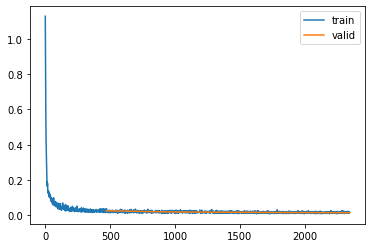

In [13]:
learn.fit(epochs)

In [14]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [15]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [16]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

## Inference

Now that we've trained our model, let's generate some images with our model:

In [17]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32)) # so here we're going to produce 16 images of shape 1x32x32 
len(samples)

1000

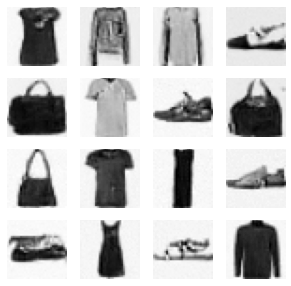

In [18]:
show_images(-samples[-1], figsize=(5,5)) # we're taking the last samples (samples[-1]) because that's our last generation  

Not bad at all, and it's training quickly, just a few minutes.

Let's visualize the sampling process:

In [ ]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10  # we're showing the results only from timesteps 800 to 1000 because 
                                                    #  between 0 and 800 there is very little change, it's just noisy images
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: <object object>


Note that I only take the steps between 800 and 1000 since most of the previous steps are actually quite noisy. This is a limitation of the noise schedule used for small images, and papers like [Improved DDPM](https://arxiv.org/abs/2102.09672) suggest other noise schedules for this purpose! (Some potential homework: try out the noise schedule from Improved DDPM and see if it helps.)

(so between 0 and 800 it's kind of wasted time because it is doing nothing and so there is room for improvement)

What we mean by noise schedule is: how beta is defined